In [1]:
import sys
sys.path.append('/home/jovyan/repo/tx-fast-hydrology')

# Import modules

In [2]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Load model collection

In [3]:
# Define model file input path
input_path = '../data/travis-county-hi-res-model.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Sub-models')

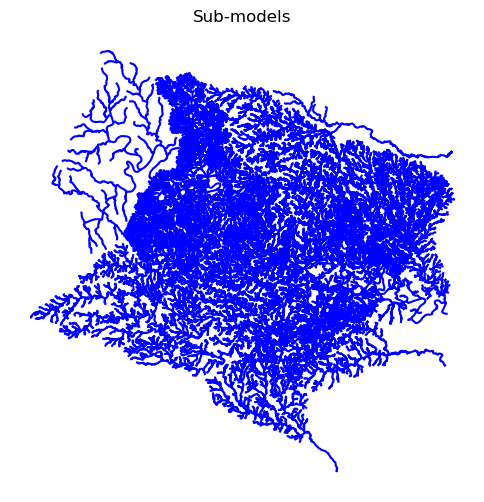

In [4]:
# Plot model collection with sub-models in different colors
fig, ax = plt.subplots(figsize=(6,6))
for model_name, model in model_collection.models.items():
    model.plot(ax=ax, c='b')
plt.axis('off')
plt.title('Sub-models')

# Create model inputs

### Load NWM forcings

In [5]:
# Define path for NWM forcings
forcing_path = '../data/20210528_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20210528', '20210529', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Create inputs to model based on forcings

In [6]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
store = pd.HDFStore('../data/area_fractions.h5', 'r')
hdf_keys = store.keys()
store.close()
for key in hdf_keys:
    comid = key.split('__')[-1]
    area_ratios = pd.read_hdf(f'../data/area_fractions.h5', key=key)
    for reach_id in area_ratios.index:
        if comid in forcing.columns:
            runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
            reach_id_str = str(reach_id)
            if reach_id_str in inputs.columns:
                inputs[reach_id_str] += runoff_proportion

# Add inflow to upstream boundary reaches
upstream_inputs = {
    '5779305' : '5781161',
    '5785187' : '5785899',
    '5786029' : '5785351'
}
for downstream_reach, upstream_reach in upstream_inputs.items():
    inputs[downstream_reach] += streamflow[upstream_reach]

In [7]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

# Gather gage measurements for event period

In [8]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_densified_reach = pd.read_csv('../data/usgs_reach_id_densified.csv', index_col=0) 
usgs_to_densified_reach = usgs_to_densified_reach[['usgs_id','reach_id']].reset_index(drop=True).dropna().reset_index(drop=True)
usgs_to_densified_reach['usgs_id'] = usgs_to_densified_reach['usgs_id'].astype(int).astype(str)
usgs_to_densified_reach['reach_id'] = usgs_to_densified_reach['reach_id'].astype(int).astype(str)
# Filter 
usgs_to_densified_reach = usgs_to_densified_reach[usgs_to_densified_reach['reach_id'].isin(input_columns)]
usgs_to_densified_reach = pd.Series(usgs_to_densified_reach['reach_id'].values, index=usgs_to_densified_reach['usgs_id'].values)
usgs_to_densified_reach.drop(['8154900', '8154500'], inplace=True)


# Load table of USGS gage measurements
measurements = pd.read_hdf('../data/gages.h5', key='usgs')
measurements.columns = measurements.columns.astype(int).astype(str)
measurements = measurements[usgs_to_densified_reach.index]
measurements.columns = measurements.columns.map(usgs_to_densified_reach)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
measurements = measurements.dropna(axis=1)
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

# Set up Kalman Filter

In [9]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 0.5 * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and execute simulation

### Prepare model for simulation

In [10]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [11]:
# Simulate models
outputs_da = await simulation.simulate()
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)

/home/jovyan/repo/tx-fast-hydrology/tx_fast_hydrology/da.py:122: RuntimeWarning: overflow encountered in matmul
  P_t_next = P_t_next - K @ P_t_next[s]
/home/jovyan/repo/tx-fast-hydrology/tx_fast_hydrology/da.py:122: RuntimeWarning: invalid value encountered in subtract
  P_t_next = P_t_next - K @ P_t_next[s]
/home/jovyan/repo/tx-fast-hydrology/tx_fast_hydrology/da.py:122: RuntimeWarning: overflow encountered in matmul
  P_t_next = P_t_next - K @ P_t_next[s]
/home/jovyan/repo/tx-fast-hydrology/tx_fast_hydrology/da.py:122: RuntimeWarning: overflow encountered in matmul
  P_t_next = P_t_next - K @ P_t_next[s]
/home/jovyan/repo/tx-fast-hydrology/tx_fast_hydrology/da.py:122: RuntimeWarning: overflow encountered in matmul
  P_t_next = P_t_next - K @ P_t_next[s]
/home/jovyan/repo/tx-fast-hydrology/tx_fast_hydrology/da.py:122: RuntimeWarning: overflow encountered in matmul
  P_t_next = P_t_next - K @ P_t_next[s]
/home/jovyan/repo/tx-fast-hydrology/tx_fast_hydrology/da.py:122: RuntimeWarning: 

In [35]:
outputs_da.dropna()

,2328595,2327746,2328515,2327750,2327886,2327626,2324272,2328361,2328243,2327437,...,2372607,2372501,2342045,2368883,2369744,2352504,2372974,2370054,2370231,2381839
2021-05-27 23:59:50+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.253675e-57
2021-05-28 00:00:00+00:00,0.000006,0.000002,0.000008,0.000016,0.000007,0.000003,0.000004,-1.106999e-06,0.000003,0.000003,...,1.740416e-09,6.224582e-08,1.719595e-07,3.781834e-07,1.528524e-07,2.496244e-07,7.845542e-08,9.683260e-08,1.834611e-07,2.633494e-04
2021-05-28 00:00:10+00:00,0.000014,0.000007,0.000014,0.000030,0.000014,0.000006,0.000006,-6.578126e-07,0.000004,0.000006,...,3.791313e-08,1.424497e-07,3.135143e-07,1.269815e-06,2.921126e-07,4.522775e-07,3.455536e-08,5.563641e-07,7.962933e-07,5.261108e-04
2021-05-28 00:00:20+00:00,0.000022,0.000013,0.000020,0.000043,0.000021,0.000009,0.000006,1.010166e-06,0.000010,0.000008,...,1.003387e-07,2.166247e-07,4.300404e-07,2.101203e-06,4.189891e-07,6.167978e-07,-3.660191e-08,1.104490e-06,1.375414e-06,7.866597e-04
2021-05-28 00:00:30+00:00,0.000031,0.000021,0.000026,0.000056,0.000028,0.000013,0.000006,3.616321e-06,0.000032,0.000011,...,1.840768e-07,2.894657e-07,5.259632e-07,2.884607e-06,5.345832e-07,7.503606e-07,3.226474e-07,1.666155e-06,2.074072e-06,1.044001e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28 05:42:30+00:00,0.000520,0.046869,0.000266,0.000800,0.000716,0.001654,0.000619,1.050127e-04,0.001525,0.000228,...,7.515262e-05,7.920467e-07,9.725505e-07,1.033340e-04,1.718905e-06,1.326604e-06,3.861334e-06,9.103424e-04,2.804779e-05,-1.084703e+262
2021-05-28 05:42:40+00:00,0.000520,0.046928,0.000267,0.000801,0.000717,0.001654,0.000619,1.050127e-04,0.001527,0.000228,...,7.515262e-05,7.920467e-07,9.725505e-07,1.033340e-04,1.718905e-06,1.326604e-06,3.861334e-06,9.103424e-04,2.804779e-05,1.619679e+262
2021-05-28 05:42:50+00:00,0.000521,0.046988,0.000267,0.000802,0.000718,0.001654,0.000620,1.050127e-04,0.001529,0.000228,...,7.515262e-05,7.920467e-07,9.725505e-07,1.033340e-04,1.718905e-06,1.326604e-06,3.861334e-06,9.103424e-04,2.804779e-05,-2.417550e+262
2021-05-28 05:43:00+00:00,0.000522,0.047047,0.000267,0.000803,0.000718,0.001654,0.000621,1.050127e-04,0.001531,0.000228,...,7.515262e-05,7.920467e-07,9.725505e-07,1.033340e-04,1.718905e-06,1.326604e-06,3.861334e-06,9.103425e-04,2.804779e-05,3.607013e+262


In [22]:
out = outputs_da.dropna()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))


for model in model_collection.models.values():
    outlet = np.asarray(model.reach_ids)[model.startnodes == model.endnodes].item()
    out[outlet].plot(ax=ax, legend=False)
plt.xlabel('Time')
plt.ylabel('Discharge [cms]')
plt.title('Travis County Model: Discharge response to storm event on 8/22/22')

# Compare results

### Run model without DA

In [24]:
# Define model file input path
input_path = '../data/travis-county-hi-res-model.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

# Simulate models
outputs_noda = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda.values()], axis=1)

In [34]:
outputs_noda

,2328595,2327746,2328515,2327750,2327886,2327626,2324272,2328361,2328243,2327437,...,2372607,2372501,2342045,2368883,2369744,2352504,2372974,2370054,2370231,2381839
2021-05-27 23:59:50+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2021-05-28 00:00:00+00:00,0.000006,0.000002,0.000008,0.000016,0.000007,0.000003,0.000004,-1.106999e-06,0.000003,0.000003,...,1.740416e-09,6.224582e-08,1.719595e-07,3.781834e-07,1.528524e-07,2.496244e-07,7.845542e-08,9.683260e-08,1.834611e-07,0.000263
2021-05-28 00:00:10+00:00,0.000014,0.000007,0.000014,0.000030,0.000014,0.000006,0.000006,-6.578126e-07,0.000004,0.000006,...,3.791313e-08,1.424497e-07,3.135143e-07,1.269815e-06,2.921126e-07,4.522775e-07,3.455536e-08,5.563641e-07,7.962933e-07,0.000526
2021-05-28 00:00:20+00:00,0.000022,0.000013,0.000020,0.000043,0.000021,0.000009,0.000006,1.010166e-06,0.000010,0.000008,...,1.003387e-07,2.166247e-07,4.300404e-07,2.101203e-06,4.189891e-07,6.167978e-07,-3.660191e-08,1.104490e-06,1.375414e-06,0.000787
2021-05-28 00:00:30+00:00,0.000031,0.000021,0.000026,0.000056,0.000028,0.000013,0.000006,3.616321e-06,0.000032,0.000011,...,1.840768e-07,2.894657e-07,5.259632e-07,2.884607e-06,5.345832e-07,7.503606e-07,3.226474e-07,1.666155e-06,2.074072e-06,0.001044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28 22:59:20+00:00,0.000021,0.002478,0.000011,0.000033,0.000030,0.000044,0.000026,1.080566e-04,0.000063,0.000235,...,7.767530e-05,7.920467e-07,9.725505e-07,1.060064e-04,1.800758e-06,1.373983e-06,3.861334e-06,9.198071e-04,2.877687e-05,24.361722
2021-05-28 22:59:30+00:00,0.000021,0.002478,0.000011,0.000033,0.000030,0.000044,0.000026,1.080566e-04,0.000063,0.000235,...,7.767530e-05,7.920467e-07,9.725505e-07,1.060072e-04,1.800758e-06,1.373983e-06,3.861334e-06,9.198071e-04,2.877710e-05,24.362766
2021-05-28 22:59:40+00:00,0.000021,0.002478,0.000011,0.000033,0.000030,0.000044,0.000026,1.080566e-04,0.000063,0.000235,...,7.767530e-05,7.920467e-07,9.725505e-07,1.060081e-04,1.800758e-06,1.373983e-06,3.861334e-06,9.198071e-04,2.877733e-05,24.363816
2021-05-28 22:59:50+00:00,0.000021,0.002478,0.000011,0.000033,0.000030,0.000044,0.000026,1.080566e-04,0.000063,0.000235,...,7.767530e-05,7.920467e-07,9.725505e-07,1.060089e-04,1.800758e-06,1.373983e-06,3.861334e-06,9.198071e-04,2.877755e-05,24.364874


### Plot model result vs. KF vs. measurements at gage locations

IndexError: index 27 is out of bounds for axis 0 with size 27

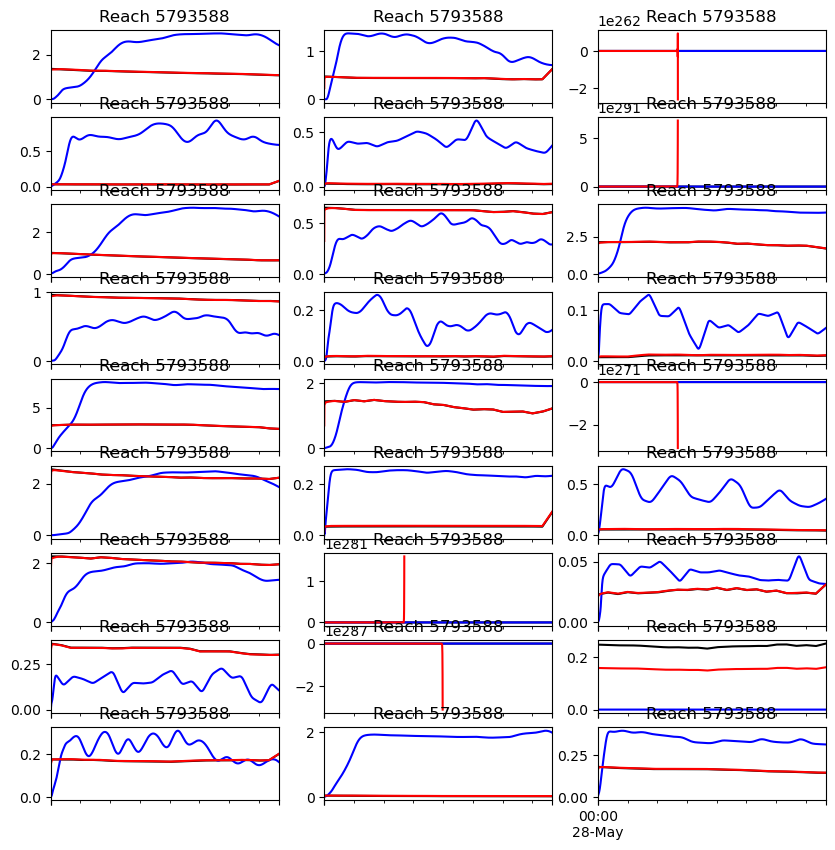

In [25]:
fig, ax = plt.subplots(measurements.columns.size // 3, 3, figsize=(10, 10))

for index, reach_id in enumerate(measurements.columns):
    measurements[reach_id].plot(ax=ax.flat[index], c='k', label='Gage')
    outputs_noda[reach_id].plot(ax=ax.flat[index], c='b', label='Model')
    outputs_da[reach_id].plot(ax=ax.flat[index], c='r', label='KF')
    if index < measurements.columns.size - 3:
        ax.flat[index].xaxis.set_ticklabels([])
    ax.flat[index].xaxis.set_ticklabels([], minor=True)
    ax.flat[index].set_title(f'Reach {comid}')
ax.flat[0].legend()
plt.tight_layout()

### Plot map of gains

In [26]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)

/srv/conda/envs/notebook/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [29]:
den_streams_tx

,reach_id,creek_type,to_id,geometry
0,2328587,NATURAL_UNCLASSIFIED,2341989,"LINESTRING (-97.88373 30.53078, -97.88382 30.5..."
1,2328455,ALTERED_EARTHEN,2327439,"LINESTRING (-97.57610 30.45536, -97.57635 30.4..."
2,2327995,NATURAL_UNCLASSIFIED,2330140,"LINESTRING (-97.99918 30.29309, -97.99916 30.2..."
3,2328527,ALTERED_STRUCTURAL,2348336,"LINESTRING (-97.63789 30.29285, -97.63787 30.2..."
4,2327888,UNDERGROUND_CULVERT,2348283,"LINESTRING (-97.80271 30.36218, -97.80268 30.3..."
...,...,...,...,...
63455,5780413,NWM_FLOWLINE,5780405,"LINESTRING (-98.12632 30.36264, -98.12648 30.3..."
63456,5780405,NWM_FLOWLINE,5780401,"LINESTRING (-98.12906 30.37239, -98.12834 30.3..."
63457,5780401,NWM_FLOWLINE,5780395,"LINESTRING (-98.11405 30.37874, -98.11319 30.3..."
63458,5671169,NWM_FLOWLINE,5671169,"LINESTRING (-97.65242 30.53563, -97.65173 30.5..."


In [30]:
den_streams_tx = gpd.read_file('../data/travis_densified_streamlines')
den_streams_tx['reach_id'] = den_streams_tx['reach_id'].astype(int).astype(str)
den_streams_travis = den_streams_tx[den_streams_tx['reach_id'].isin(input_columns)].copy()
den_streams_travis['gain'] = den_streams_travis['reach_id'].map(total_gain).fillna(0.).values
den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

/srv/conda/envs/notebook/lib/python3.12/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/srv/conda/envs/notebook/lib/python3.12/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


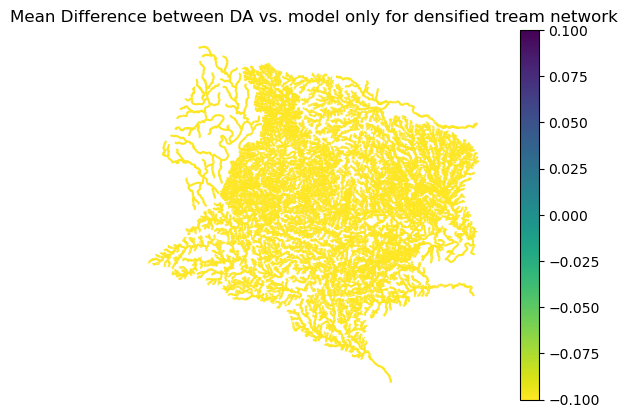

In [31]:
den_streams_travis.plot(column='gain', cmap='viridis_r', legend=True)
plt.title('Mean Difference between DA vs. model only for densified tream network')
_ = plt.axis('off')

/srv/conda/envs/notebook/lib/python3.12/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


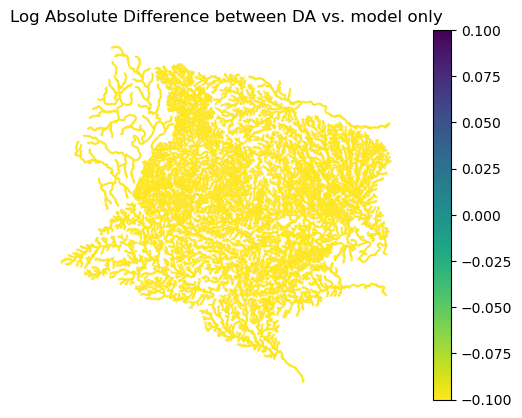

In [32]:
den_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True)
plt.title('Log Absolute Difference between DA vs. model only')
_ = plt.axis('off')